In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import pandas as pd
from skimage.segmentation import mark_boundaries, watershed

from src.data.monuseg.tf_data import get_dataset, tf_random_crop, get_split, to_sparse


In [2]:
info_df = pd.read_csv("/home/valentin/python_wkspce/2d_bispectrum_cnn/data/raw/MoNuSeg2018Training/MoNuSeg2018_info.csv")

In [3]:
info_df.columns

Index(['patient_id', 'organ', 'disease_type'], dtype='object')

In [4]:
patient_ids = info_df[info_df["organ"].isin(["Breast", "Liver", "Kidney", "Prostate"])]["patient_id"].values

In [5]:
ids_train, ids_val, ids_test = get_split()

In [6]:
ids_train

['TCGA-E2-A14V-01Z-00-DX1',
 'TCGA-A7-A13F-01Z-00-DX1',
 'TCGA-E2-A1B5-01Z-00-DX1',
 'TCGA-21-5784-01Z-00-DX1',
 'TCGA-18-5592-01Z-00-DX1',
 'TCGA-21-5786-01Z-00-DX1',
 'TCGA-B0-5698-01Z-00-DX1',
 'TCGA-B0-5711-01Z-00-DX1',
 'TCGA-HE-7130-01Z-00-DX1',
 'TCGA-G9-6362-01Z-00-DX1',
 'TCGA-CH-5767-01Z-00-DX1',
 'TCGA-G9-6363-01Z-00-DX1']

In [7]:
ds = get_dataset(id_list=patient_ids).map(
    lambda x, y: tf_random_crop(x, y, rotation_angle="right-angle", filter_segmentation=False)).map(
        lambda x, y: (x, to_sparse(y))).as_numpy_iterator()
# ds = get_dataset(id_list=patient_ids).as_numpy_iterator()


In [8]:
image, mask = next(ds)

In [9]:
image.shape

(256, 256, 3)

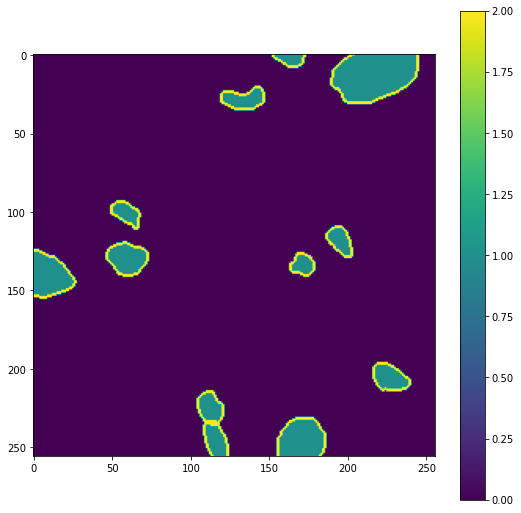

In [10]:
plt.figure(figsize=(9,9))
plt.imshow(mask[:,:,0])
plt.colorbar()

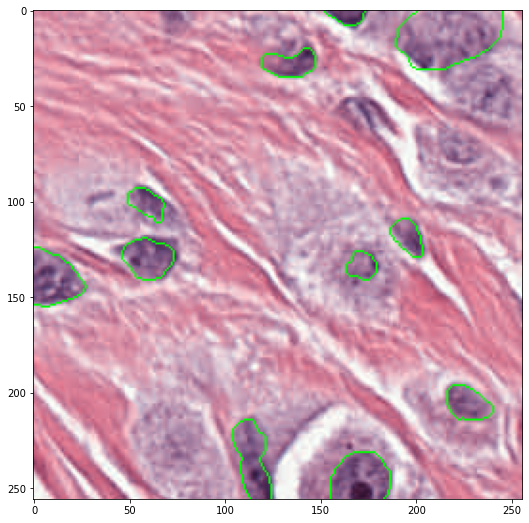

In [11]:
image_annotated = mark_boundaries(
    image,
    mask[:, :, 0].astype(bool),
    color=(0, 1, 0),
    mode="inner"
)
plt.figure(figsize=(9, 9))
plt.imshow(image_annotated)

In [13]:
ds = get_dataset(id_list=patient_ids).as_numpy_iterator()
n_background = 0
n_foreground = 0
n_border = 0
for image, seg in ds:
    n_border += np.sum(seg[:, :, 1])
    n_foreground += np.sum(seg[:, :, 0])
    n_background += np.sum(seg[:, :, 2])
ratio_foreground = n_foreground / (n_background + n_foreground + n_border)
ratio_border = n_border / (n_background + n_foreground + n_border)
ratio_background = n_background / (n_background + n_foreground + n_border)
print(
    f"The ratio of foreground, border and backgroun are {ratio_foreground}, {ratio_border}, {ratio_background}, respectively "
)
print(
    f"The alpha of foreground, border and backgroun are {1-ratio_foreground}, {1-ratio_border}, {1-ratio_background}, respectively "
)
print(
    f"The class weights of foreground, border and backgroun are {1/ratio_foreground/3}, {1/ratio_border/3}, {1/ratio_background/3}, respectively "
)

The ratio of foreground, border and backgroun are 0.17893920833333332, 0.06716829166666667, 0.7538925, respectively 
The alpha of foreground, border and backgroun are 0.8210607916666667, 0.9328317083333333, 0.24610750000000003, respectively 
The class weights of foreground, border and backgroun are 1.8628300440023742, 4.962659091994673, 0.442149687565977, respectively 


In [ ]:
n_background + n_foreground + n_border

In [ ]:
w = watershed(mask[:, :, 1], mask=mask[:, :, 0])


In [ ]:
plt.imshow(w)
plt.colorbar()

In [ ]:
w.shape